In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# --- SETUP ---
BASE_URL = "https://www.jumia.com.ng/android-phones/?page={}"
all_phones_data = []

# --- PART 1: THE SCRAPING LOOP ---
# Scan pages 1 to 50
for page in range(1, 50):
    url = BASE_URL.format(page)
    print(f"Scraping Page {page}...")

    try:
        response = requests.get(url)
        # Use lxml if you have it installed, otherwise html.parser
        soup = BeautifulSoup(response.text, "html.parser")
        
        items = soup.find_all("article", class_="prd")

        # If page is empty, stop
        if not items:
            print("No items found. Stopping.")
            break

        for item in items:
            try:
                # --- EXTRACT RAW DATA ---
                
                # Name
                title_tag = item.find("h3", class_="name")
                name = title_tag.text.strip() if title_tag else None

                # Price (Raw text like "₦ 120,000")
                price_tag = item.find("div", class_="prc")
                price = price_tag.text.strip() if price_tag else None

                # Old Price (Raw text like "₦ 150,000")
                old_tag = item.find("div", class_="old")
                old_price = old_tag.text.strip() if old_tag else None

                # Rating
                rating_tag = item.find("div", class_="stars _s")
                rating = rating_tag.text.strip() if rating_tag else None

                # Reviews (Cleaned brackets immediately)
                rev_tag = item.find("div", class_="rev")
                if rev_tag:
                    reviews = rev_tag.text.strip().replace("(", "").replace(")", "")
                else:
                    reviews = "0"

                # Official Store (Verified Seller)
                # We use select_one because it finds ".bdg" AND "._mall" even if they have extra spaces
                official_tag = item.select_one(".bdg._mall") 
                is_official = "Yes" if official_tag else "No"

                # Product Link
                link_tag = item.find("a")
                full_link = None
                if link_tag:
                    href = link_tag.get("href")
                    if href:
                        full_link = "https://www.jumia.com.ng" + href

                # Add raw data to list
                all_phones_data.append({
                    "Phone Name": name,
                    "Brand": name.split()[0] if name else None,
                    "Price": price,
                    "Old Price": old_price,
                    "Rating": rating,
                    "Verified Reviews": reviews,
                    "Official Store": is_official,
                    "Product Link": full_link
                })
            
            except Exception as e:
                continue
        
        # Pause to be polite to the server
        time.sleep(0.5)

    except Exception as e:
        print(f"Error loading page {page}: {e}")

# --- PART 2: CREATE DATAFRAME ---
print("Scraping finished. Processing data...")
df = pd.DataFrame(all_phones_data)

# --- PART 3: CALCULATIONS & CLEANING (Do this AFTER creating df) ---

# 1. Clean the Currency Symbols (Remove '₦' and ',')
# We use .astype(str) to make sure we don't crash on empty values
df["Price_Num"] = df["Price"].astype(str).str.replace("₦", "").str.replace(",", "").str.strip()
df["Old_Price_Num"] = df["Old Price"].astype(str).str.replace("₦", "").str.replace(",", "").str.strip()

# 2. Convert to Numbers
df["Price_Num"] = pd.to_numeric(df["Price_Num"], errors="coerce")
df["Old_Price_Num"] = pd.to_numeric(df["Old_Price_Num"], errors="coerce")

# 3. Calculate Discount Percentage
# Formula: ((Old - New) / Old) * 100
df["Calculated Discount"] = ((df["Old_Price_Num"] - df["Price_Num"]) / df["Old_Price_Num"]) * 100
df["Calculated Discount"] = df["Calculated Discount"].round(1) # Round to 1 decimal

# 4. Fill NaN discounts with 0 (for phones that had no discount)
df["Calculated Discount"] = df["Calculated Discount"].fillna(0)

# --- PART 4: SAVE ---
df.to_csv("jumia_phones_final.csv", index=False)
print(f"Success! Saved {len(df)} phones to jumia_phones_final.csv")

# Show a preview
print(df[["Phone Name", "Price", "Calculated Discount", "Official Store"]].head())

Scraping Page 1...
Scraping Page 2...
Scraping Page 3...
Scraping Page 4...
Scraping Page 5...
Scraping Page 6...
Scraping Page 7...
Scraping Page 8...
Scraping Page 9...
Scraping Page 10...
Scraping Page 11...
Scraping Page 12...
Scraping Page 13...
Scraping Page 14...
Scraping Page 15...
Scraping Page 16...
Scraping Page 17...
Scraping Page 18...
Scraping Page 19...
Scraping Page 20...
Scraping Page 21...
Scraping Page 22...
Scraping Page 23...
Scraping Page 24...
Scraping Page 25...
Scraping Page 26...
Scraping Page 27...
Scraping Page 28...
Scraping Page 29...
Scraping Page 30...
Scraping Page 31...
Scraping Page 32...
Scraping Page 33...
Scraping Page 34...
Scraping Page 35...
Scraping Page 36...
Scraping Page 37...
Scraping Page 38...
Scraping Page 39...
Scraping Page 40...
Scraping Page 41...
Scraping Page 42...
Scraping Page 43...
Scraping Page 44...
Scraping Page 45...
Scraping Page 46...
Scraping Page 47...
Scraping Page 48...
Scraping Page 49...
Scraping finished. Processing

In [44]:
#to get the brief representation of the code i ran,
import pandas as pd

df = pd.read_csv("jumia_phones.csv")
df.head()


,Phone Name,Brand,Price,Old Price,Rating,Verified Reviews,Official Store,Product Link,Price_Num,Old_Price_Num,Calculated Discount
0,XIAOMI REDMI A5 - 6.88 4GB RAM/128GB ROM -...,XIAOMI,"₦ 102,227","₦ 111,742",4.1 out of 5,4.1 out of 5858,Yes,NaN,102227.0,111742.0,8.5
1,XIAOMI Redmi 15C 6.9'' 4GB RAM/128GB ROM Andro...,XIAOMI,"₦ 124,143","₦ 136,125",4.2 out of 5,4.2 out of 5169,Yes,NaN,124143.0,136125.0,8.8
2,XIAOMI REDMI A5 - 6.88 3GB RAM/64GB ROM --...,XIAOMI,"₦ 88,900","₦ 98,036",4 out of 5,4 out of 5296,Yes,NaN,88900.0,98036.0,9.3
3,"XIAOMI Redmi A3 Pro 6.88"" 4GB RAM / 128GB ROM ...",XIAOMI,"₦ 108,381","₦ 127,990",4 out of 5,4 out of 5224,Yes,https://www.jumia.com.ng/customer/account/logi...,108381.0,127990.0,15.3
4,XIAOMI Redmi 15C 6.9'' 4GBRAM/128GB ROM Androi...,XIAOMI,"₦ 124,143","₦ 144,235",4.2 out of 5,4.2 out of 558,Yes,NaN,124143.0,144235.0,13.9


In [46]:
# We convert to string first to avoid the "AttributeError: ... not floating"
df["Rating"] = df["Rating"].astype(str).str.extract(r"(\d\.?\d?)")

# Convert the cleaned string back to numbers for further calculations
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

# 2. Extract Brand from Phone Name
# We also ensure Phone Name is a string just in case there are missing values
df["Brand"] = df["Phone Name"].astype(str).str.split().str[0]

# Check the results
print(df[["Brand", "Rating"]].head())

    Brand  Rating
0  XIAOMI     4.1
1  XIAOMI     4.2
2  XIAOMI     4.0
3  XIAOMI     4.0
4  XIAOMI     4.2


In [47]:
#To check how many empty columns are there on each row
df.isnull().sum()

Phone Name                0
Brand                     0
Price                     3
Old Price               665
Rating                 1127
Verified Reviews          0
Official Store            0
Product Link            494
Price_Num                 3
Old_Price_Num           665
Calculated Discount       0
dtype: int64

In [23]:
#summary of the data set
df.describe()

,Rating
count,1911.000000
mean,4.146154
std,0.610265
min,1.000000
25%,4.000000
50%,4.200000
75%,4.500000
max,4.800000


In [48]:
#to check the brands and their number of products
df["Brand"].value_counts().head(10)

Brand
Samsung    750
XIAOMI     217
Tecno      129
itel       116
Infinix    108
Oppo        49
Google      36
Realme      35
Poco        34
Vivo        33
Name: count, dtype: int64

In [52]:
# --- 1. Clean the Brand Names ---
# Convert to Title Case (so "tecno" and "Tecno" become the same)
df["Brand"] = df["Brand"].str.title()

# Filter out "Junk" brands (words that aren't actually brands)
# We only keep brands that appear at least 3 times to remove noise like "New", "Global", "2pcs"
valid_brands = df["Brand"].value_counts()
popular_brands_list = valid_brands[valid_brands > 3].index
df_clean = df[df["Brand"].isin(popular_brands_list)].copy()

# --- 2. Ensure Numbers are Clean ---
# Force "Verified Reviews" to be numbers, turn errors into 0
df_clean["Verified Reviews"] = pd.to_numeric(df_clean["Verified Reviews"], errors='coerce').fillna(0)

print("Data Cleaned.")
print("Top 10 Brands found:", df_clean["Brand"].value_counts().head(10).index.tolist())

Data Cleaned.
Top 10 Brands found: ['Samsung', 'Xiaomi', 'Tecno', 'Itel', 'Infinix', 'Oppo', 'Google', 'Realme', 'Huawei', 'Poco']


In [55]:
#to know the pwrcentage of the products listed either on the offical store or by other vendors
# We switch to counting 'Phone Name' just in case Reviews are all 0
brand_analysis = df.pivot_table(
    index="Brand", 
    columns="Official Store", 
    values="Phone Name",  # Changed to count LISTINGS instead of SALES for now
    aggfunc="count", 
    fill_value=0
)

# --- 2. Fix Columns ---
if "Yes" not in brand_analysis.columns: brand_analysis["Yes"] = 0
if "No" not in brand_analysis.columns: brand_analysis["No"] = 0

# --- 3. Calculate Percentages ---
brand_analysis["Total"] = brand_analysis["Yes"] + brand_analysis["No"]
brand_analysis["Official %"] = (brand_analysis["Yes"] / brand_analysis["Total"]) * 100
brand_analysis["Others %"] = (brand_analysis["No"] / brand_analysis["Total"]) * 100

# --- 4. Display (Sort by whoever has the most phones listed) ---
brand_analysis = brand_analysis.sort_values(by="Total", ascending=False)
final_view = brand_analysis[["Official %", "Others %"]].astype(int).astype(str) + "%"

print("--- Inventory Share: Official vs Others ---")
display(final_view.head(10))

--- Inventory Share: Official vs Others ---


Official Store,Official %,Others %
Brand,,
Samsung,5%,94%
Xiaomi,12%,87%
Tecno,11%,88%
Itel,18%,81%
Infinix,16%,83%
Oppo,5%,94%
Google,0%,100%
Realme,22%,77%
Huawei,0%,100%


In [56]:
# Check 1: Do we have any data at all?
print(f"Total rows in df: {len(df)}")

# Check 2: Did we find any Official Stores?
print("Official Store counts:")
print(df["Official Store"].value_counts())

# Check 3: Did we capture any Reviews?
# (If this sums to 0, that's why the table is empty)
print(f"Total Reviews Captured: {df['Verified Reviews'].astype(int).sum()}")

# Check 4: What are the top brands right now?
print("Top 5 Brands found:")
print(df["Brand"].value_counts().head(5))

Total rows in df: 1760
Official Store counts:
Official Store
No     1599
Yes     161
Name: count, dtype: int64
Total Reviews Captured: 0
Top 5 Brands found:
Brand
Samsung    750
Xiaomi     217
Tecno      129
Itel       116
Infinix    108
Name: count, dtype: int64


In [3]:
!pip install matplotlib

ffmpeg version 2025-09-28-git-0fdb5829e3-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjx

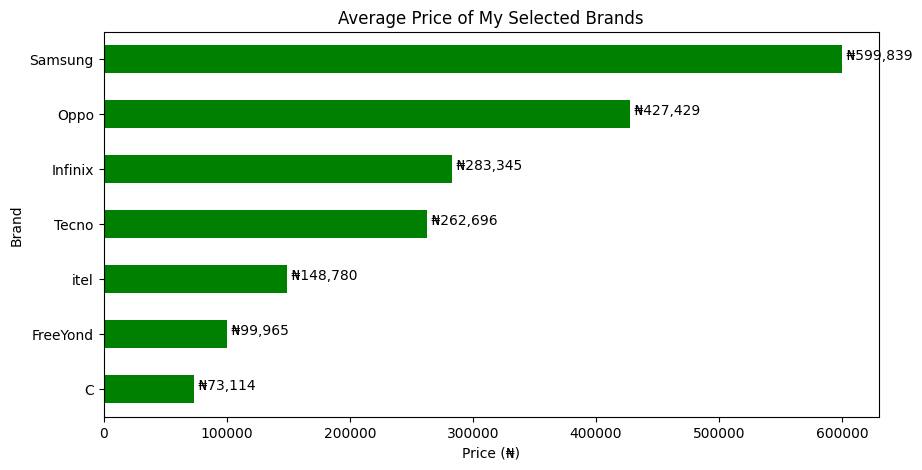

In [5]:
import matplotlib.pyplot as plt

# 1. Select ONLY the brands you want to see
my_brands = ["Infinix", "Tecno", "itel", "Samsung", "Xiaomi", "Oppo", "Redmi", "FreeYond", "C", "POCO", "ACM"]

# 2. Filter your data to find these specific names
# We use .isin() to grab only the rows that match your list
my_subset = df[df["Brand"].isin(my_brands)]

# 3. Plot them
if not my_subset.empty:
    # We group by Brand and get the Mean Price
    avg_prices = my_subset.groupby("Brand")["Price"].mean().sort_values()
    
    # Create the chart
    avg_prices.plot(kind="barh", color="green", figsize=(10, 5))
    plt.title("Average Price of My Selected Brands")
    plt.xlabel("Price (₦)")
    
    # Add labels to the bars so you can see the exact prices
    for index, value in enumerate(avg_prices):
        plt.text(value, index, f" ₦{value:,.0f}")
        
    plt.show()
else:
    print("Error: Could not find these brands. Check if they are spelled correctly in your 'Brand' column.")
    # Debugging: Print all unique brands found to check spelling
    print("Brands actually found in data:", df["Brand"].unique())

Success! Loaded 'jumia_phones_final.csv'


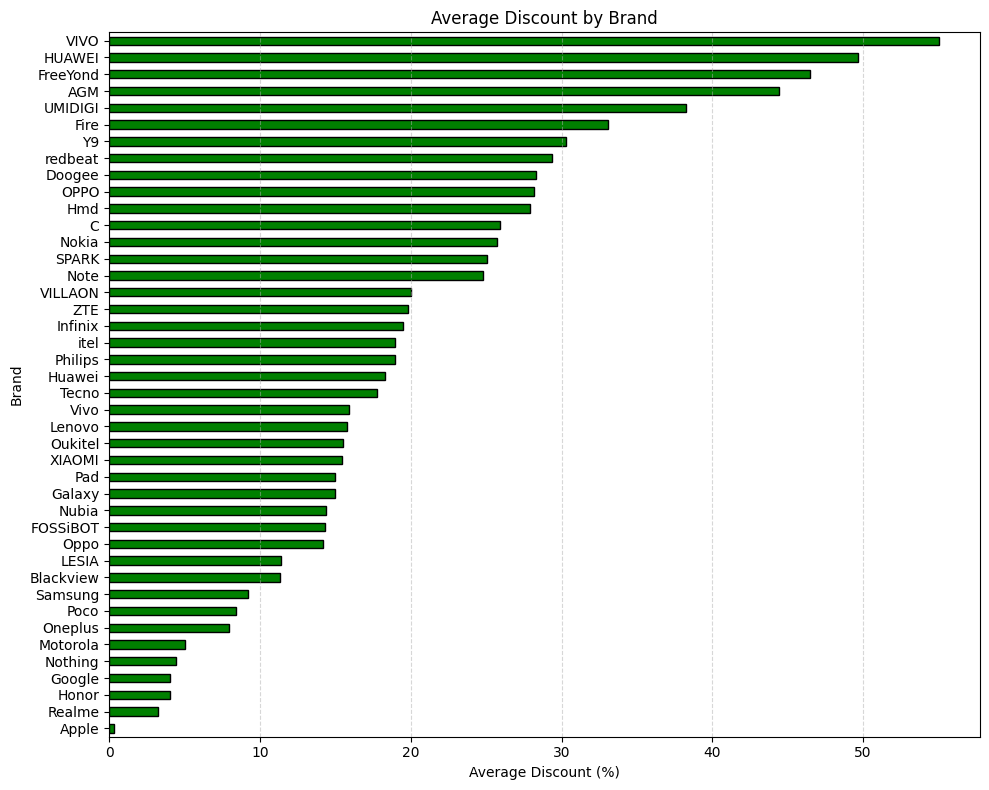

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD THE SAVED DATA
# We try to load the file you created earlier.
# (Based on your screenshots, you named it 'jumia_phones_final.csv' or 'jumia_phones.csv')
try:
    df = pd.read_csv("jumia_phones_final.csv")
    print("Success! Loaded 'jumia_phones_final.csv'")
except FileNotFoundError:
    try:
        df = pd.read_csv("jumia_phones.csv")
        print("Success! Loaded 'jumia_phones.csv'")
    except FileNotFoundError:
        print("Error: Could not find your CSV file. Please check the file name on the left sidebar.")

# 2. CALCULATE AVERAGE DISCOUNT
# (We filter out brands with 0 listings to keep the chart clean)
if 'df' in locals():
    # Group by Brand and get the average discount
    brand_discounts = df.groupby("Brand")["Calculated Discount"].mean().sort_values()

    # Filter: Only show brands that have at least some discount data
    brand_discounts = brand_discounts[brand_discounts > 0]

    # 3. PLOT
    plt.figure(figsize=(10, 8)) # Make it tall enough to read
    brand_discounts.plot(kind="barh", color="green", edgecolor="black")

    plt.title("Average Discount by Brand")
    plt.xlabel("Average Discount (%)")
    plt.ylabel("Brand")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout() # Ensures brand names don't get cut off
    plt.show()